In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

2024-12-05 15:40:30.294145: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733413230.319110    3339 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733413230.325600    3339 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-05 15:40:30.348340: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
base = '/home/rob/'
csv_file = os.path.join(base, 'ham10000_data/HAM10000_metadata.csv')
img_dir = os.path.join(base, 'ham10000_data/images')
file_ext = '.jpg'

df = pd.read_csv(csv_file)
df['image_path'] = df['image_id'].apply(lambda x: os.path.join(img_dir, x + file_ext))

print(df.head())


     lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                        image_path  
0  /home/rob/ham10000_data/images/ISIC_0027419.jpg  
1  /home/rob/ham10000_data/images/ISIC_0025030.jpg  
2  /home/rob/ham10000_data/images/ISIC_0026769.jpg  
3  /home/rob/ham10000_data/images/ISIC_0025661.jpg  
4  /home/rob/ham10000_data/images/ISIC_0031633.jpg  


In [3]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in sss.split(df, df['dx']):
    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

print("Train size: ", len(train_df))
print("Train sizes per label and percentage:")
train_counts = train_df['dx'].value_counts()
train_percentages = (train_counts / len(train_df)) * 100
print(train_counts)
print(train_percentages)

print("\nTest size: ", len(test_df))
print("Test sizes per label and percentage:")
test_counts = test_df['dx'].value_counts()
test_percentages = (test_counts / len(test_df)) * 100
print(test_counts)
print(test_percentages)

Train size:  8012
Train sizes per label and percentage:
dx
nv       5364
mel       890
bkl       879
bcc       411
akiec     262
vasc      114
df         92
Name: count, dtype: int64
dx
nv       66.949576
mel      11.108337
bkl      10.971043
bcc       5.129805
akiec     3.270095
vasc      1.422866
df        1.148278
Name: count, dtype: float64

Test size:  2003
Test sizes per label and percentage:
dx
nv       1341
mel       223
bkl       220
bcc       103
akiec      65
vasc       28
df         23
Name: count, dtype: int64
dx
nv       66.949576
mel      11.133300
bkl      10.983525
bcc       5.142287
akiec     3.245132
vasc      1.397903
df        1.148278
Name: count, dtype: float64


In [4]:
IMG_SIZE = 224
BATCH_SIZE = 32

datagen_train = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen_test = ImageDataGenerator(rescale=1.0/255.0)

train_generator = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='dx',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

test_generator = datagen_test.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='dx',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42,
)

class_names = [key for key, _ in sorted(train_generator.class_indices.items(), key=lambda item: item[1])]

train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, IMG_SIZE, IMG_SIZE, 3], [None, len(class_names)])
).repeat()
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(
    lambda: test_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, IMG_SIZE, IMG_SIZE, 3], [None, len(class_names)])
).repeat()
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

print("Class Names:", class_names)
print("Train Generator Class Indices:", train_generator.class_indices)
print("Test Generator Class Indices:", test_generator.class_indices)

Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.
Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead
Class Names: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Train Generator Class Indices: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
Test Generator Class Indices: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


I0000 00:00:1733413233.378315    3339 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 205 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:0b:00.0, compute capability: 6.0
I0000 00:00:1733413233.378965    3339 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 15259 MB memory:  -> device: 1, name: Tesla P100-PCIE-16GB, pci bus id: 0000:13:00.0, compute capability: 6.0
2024-12-05 15:40:33.399674: I external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1193] failed to allocate 205.12MiB (215089152 bytes) from device: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory


In [5]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
output = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


In [6]:
def focal_loss(alpha=0.25, gamma=2.0):
    """
    Focal Loss for one-hot encoded multi-class data.

    Parameters:
    - alpha: Weighting factor for positive classes, default is 0.25.
    - gamma: Focusing parameter to reduce the loss contribution from well-classified examples, default is 2.0.

    Returns:
    - A callable loss function for use with Keras models.
    """
    def focal_loss_fixed(y_true, y_pred):
        # Clip predictions to prevent log(0)
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1. - tf.keras.backend.epsilon())

        # Compute focal loss components
        cross_entropy = -y_true * tf.math.log(y_pred)
        weights = alpha * y_true * tf.math.pow(1 - y_pred, gamma)

        # Compute weighted loss
        focal_loss = tf.reduce_sum(weights * cross_entropy, axis=-1)
        return tf.reduce_mean(focal_loss)

    return focal_loss_fixed


In [7]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=focal_loss(),
    metrics=['accuracy']
)

In [8]:
model_path = 'models/best_model_resnet50.keras'

callbacks = [
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=7, verbose=1, restore_best_weights=True),
    ModelCheckpoint(filepath=model_path, save_best_only=True, monitor='val_accuracy', verbose=1)
]

In [9]:
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.array(class_names),
    y=df['dx']
)

class_weights_dict = {
    train_generator.class_indices[class_name]: weight
    for class_name, weight in zip(class_names, class_weights_array)
}

print(class_weights_dict)

{0: np.float64(4.375273044997815), 1: np.float64(2.78349082823791), 2: np.float64(1.301832835044846), 3: np.float64(12.440993788819876), 4: np.float64(1.2854575792581184), 5: np.float64(0.21338020666879728), 6: np.float64(10.075452716297788)}


In [10]:
steps_per_epoch = len(train_df) // BATCH_SIZE
validation_steps = len(test_df) // BATCH_SIZE

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

Epoch 1/20


I0000 00:00:1733413242.239877    3904 service.cc:148] XLA service 0x74ea6c003730 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733413242.239916    3904 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733413242.239920    3904 service.cc:156]   StreamExecutor device (1): Tesla P100-PCIE-16GB, Compute Capability 6.0
2024-12-05 15:40:42.430935: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733413243.544010    3904 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1733413243.906146    3904 cuda_blas.cc:196] failed to create cublas handle: the resource allocation failed
E0000 00:00:1733413243.906210    3904 cuda_blas.cc:199] Failure to initialize cublas may be due to OOM (cublas needs some free memory when you initialize it, and your deep-learning framewor

UnknownError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/rob/.notebook/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/rob/.notebook/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/rob/.notebook/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/rob/.notebook/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/rob/.notebook/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/rob/.notebook/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/rob/.notebook/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/rob/.notebook/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/rob/.notebook/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/rob/.notebook/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/rob/.notebook/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/rob/.notebook/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/rob/.notebook/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/rob/.notebook/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/rob/.notebook/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/rob/.notebook/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/rob/.notebook/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_3339/3287240715.py", line 4, in <module>

  File "/home/rob/.notebook/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/rob/.notebook/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/home/rob/.notebook/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

Failed to determine best cudnn convolution algorithm for:
%cudnn-conv-bias-activation.159 = (f32[32,64,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,224,224]{3,2,1,0} %bitcast.5957, f32[64,3,7,7]{3,2,1,0} %bitcast.5959, f32[64]{0} %arg4.5), window={size=7x7 stride=2x2 pad=3_3x3_3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/conv1_conv_1/convolution" source_file="/home/rob/.notebook/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1196}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}

Original error: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16814848 bytes.

To ignore this failure and try to use a fallback algorithm (which may have suboptimal performance), use XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false.  Please also file a bug for the root cause of failing autotuning.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_iterator_11577]

In [ ]:
base_model.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=focal_loss(),
    metrics=['accuracy']
)


In [ ]:
fine_tune_history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    class_weight=class_weights_dict
)


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.1554 - loss: 4.0346
Epoch 1: val_accuracy did not improve from 0.57078
250/250 ━━━━━━━━━━━━━━━━━━━━ 208s 625ms/step - accuracy: 0.1557 - loss: 4.0330 - val_accuracy: 0.1096 - val_loss: 16.6590 - learning_rate: 1.0000e-05
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.4481 - loss: 2.0099
Epoch 2: val_accuracy did not improve from 0.57078
250/250 ━━━━━━━━━━━━━━━━━━━━ 131s 527ms/step - accuracy: 0.4482 - loss: 2.0088 - val_accuracy: 0.1142 - val_loss: 7.1120 - learning_rate: 1.0000e-05
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.5446 - loss: 1.4655
Epoch 3: val_accuracy did not improve from 0.57078
250/250 ━━━━━━━━━━━━━━━━━━━━ 133s 533ms/step - accuracy: 0.5446 - loss: 1.4649 - val_accuracy: 0.4455 - val_loss: 2.2016 - learning_rate: 1.0000e-05
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.5959 - loss: 1.1788
Epoch 4: val_accuracy did not improve from 0.57

In [ ]:
model.load_weights(model_path)


In [ ]:
loss, accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Total Predictions: {len(test_generator) * BATCH_SIZE}")

/home/rob/.notebook/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 191ms/step - accuracy: 0.7720 - loss: 0.6688
Test Loss: 0.5850198268890381
Test Accuracy: 0.7968047857284546
Total Predictions: 2016


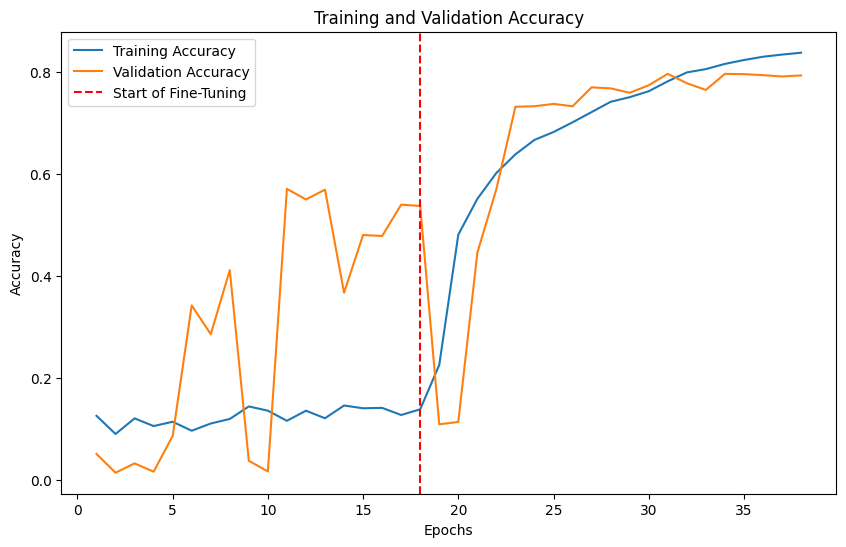

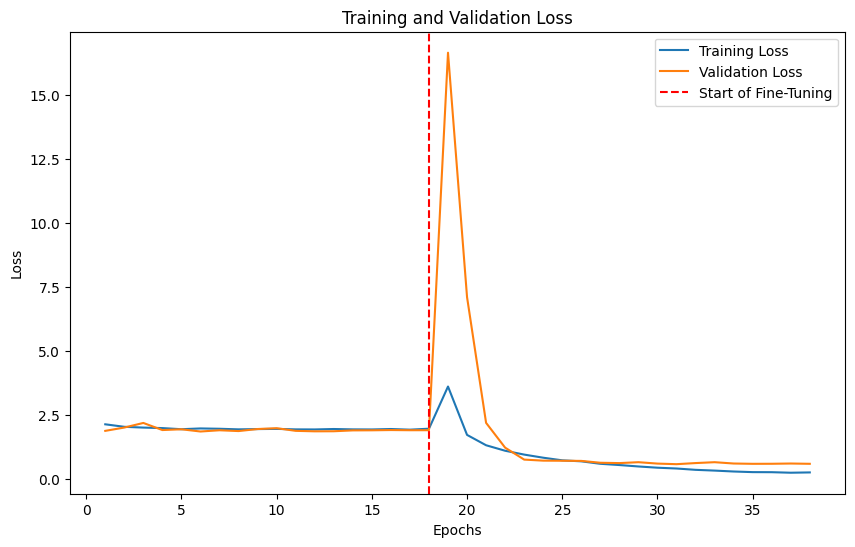

In [ ]:
accuracy = history.history['accuracy'] + fine_tune_history.history['accuracy']
val_accuracy = history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']
loss = history.history['loss'] + fine_tune_history.history['loss']
val_loss = history.history['val_loss'] + fine_tune_history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.axvline(x=len(history.history['accuracy']), color='r', linestyle='--', label='Start of Fine-Tuning')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.axvline(x=len(history.history['loss']), color='r', linestyle='--', label='Start of Fine-Tuning')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
y_pred = np.argmax(model.predict(test_generator), axis=-1)
y_true = test_generator.classes

print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

melanoma_correct = np.sum((y_pred == 3) & (y_true == 3))
print(f"Correct Melanoma Predictions: {melanoma_correct}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 245ms/step
Classification Report:
               precision    recall  f1-score   support

       akiec       0.80      0.49      0.61        65
         bcc       0.71      0.75      0.73       103
         bkl       0.54      0.76      0.63       220
          df       0.42      0.83      0.56        23
         mel       0.53      0.70      0.60       223
          nv       0.95      0.84      0.89      1341
        vasc       0.84      0.93      0.88        28

    accuracy                           0.80      2003
   macro avg       0.68      0.75      0.70      2003
weighted avg       0.84      0.80      0.81      2003

Correct Melanoma Predictions: 0


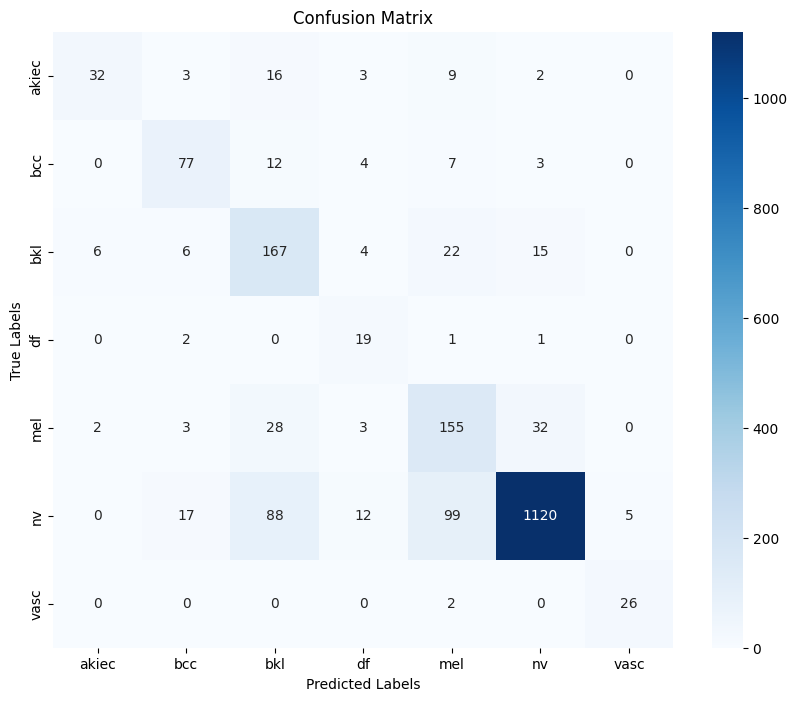

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


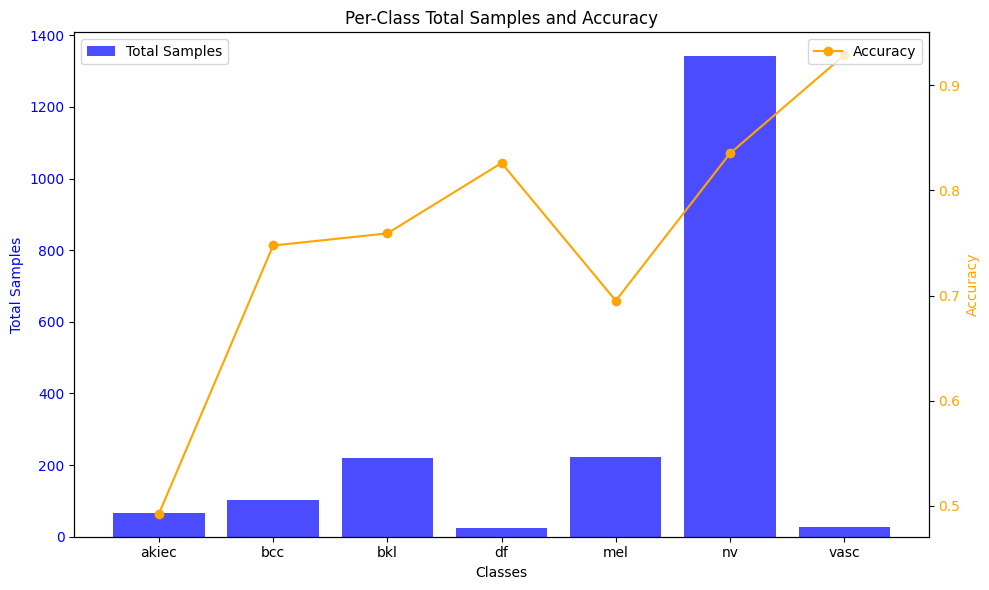

In [ ]:
label_counts = np.bincount(y_true)
class_accuracies = np.diag(cm) / label_counts

classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
total_counts = label_counts
accuracies = class_accuracies

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(classes, total_counts, alpha=0.7, label='Total Samples', color='blue')
ax1.set_xlabel('Classes')
ax1.set_ylabel('Total Samples', color='blue')
ax1.set_title('Per-Class Total Samples and Accuracy')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(classes, accuracies, color='orange', marker='o', label='Accuracy')
ax2.set_ylabel('Accuracy', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

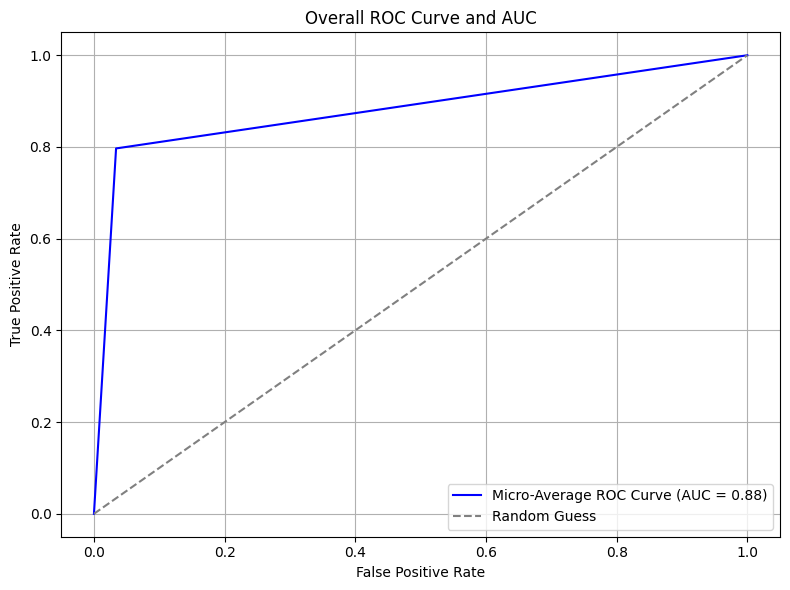

In [ ]:
# Compute overall ROC AUC for multi-class classification
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

num_classes = len(classes)
y_true_one_hot = label_binarize(y_true, classes=np.arange(num_classes))

y_pred_prob = np.zeros_like(y_true_one_hot)
for i, label in enumerate(y_pred):
    y_pred_prob[i, label] = 1

fpr, tpr, _ = roc_curve(y_true_one_hot.ravel(), y_pred_prob.ravel())
roc_auc = roc_auc_score(y_true_one_hot, y_pred_prob, average="micro")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"Micro-Average ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Overall ROC Curve and AUC")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()
